<a href="https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_intro_2_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to single-cell RNA-seq II: getting started with analysis

This notebook demonstrates pre-processing and basic analysis of the [mouse retinal cells GSE126783](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE126783) dataset from [Koren et al., 2019](https://doi.org/10.1016/j.immuni.2019.02.007). Following pre-processing using kallisto and bustools and basic QC, the notebook demonstrates some initial analysis. The approximate running time of the notebook is about 13 minutes.

The notebook was written by Kyung Hoi (Joseph) Min, A. Sina Booeshaghi and Lior Pachter. If you use the methods in this notebook for your analysis please cite the following publications which describe the tools used in the notebook, as well as specific methods they run (these are cited inline in the notebook):

* Melsted, P., Booeshaghi, A.S. et al. Modular and efficient pre-processing of single-cell RNA-seq. bioRxiv (2019). doi:10.1101/673285
* Wolf, F. A., Angere, P. and Theis, F.J. SCANPY: large-scale single-cell gene expression data analysis. Genome Biology (2018). doi:10.1186/s13059-017-1382-0

An R notebook implementing the same analysis is available [here](https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_intro_2_R.ipynb). See the [kallistobus.tools tutorials](https://www.kallistobus.tools/tutorials) site for additional notebooks demonstrating other analyses.


## Setup

In [0]:
# This is  used to time the running of the notebook
import time
start_time = time.time()

### Install python packages

In [2]:
# These packages are pre-installed on Google Colab, but are included here to facilitate running this notebook locally
!pip install matplotlib
!pip install scikit-learn
!pip install numpy
!pip install scipy

In [3]:
%%time
# `kb` is a wrapper for the kallisto and bustools program, and the kb-python package contains the kallisto and bustools executables.
!pip install kb-python==0.24.1

     |████████████████████████████████| 35.4MB 88kB/s 
     |████████████████████████████████| 102kB 12.2MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
  Created wheel for loompy: filename=loompy-3.0.6-cp36-none-any.whl size=47895 sha256=265a367f7a8ebbbe5dc026a24407ba8efae23f4bcb9c076161fb575e6a924c9f
  Stored in directory: /root/.cache/pip/wheels/f9/a4/90/5a98ad83419732b0fba533b81a2a52ba3dbe230a936ca4cdc9
  Created wheel for numpy-groupies: filename=numpy_groupies-0+unknown-cp36-none-any.whl size=28042 sha256=f7c9200d76fc6c24d29d79904d534b1d674124770d752701c6877ad4de605ac3
  Stored in directory: /root/.cache/pip/wheels/30/ac/83/64d5f9293aeaec63f9539142fc629a41af064cae1b3d8d94aa
Successfully built loompy numpy-groupies
CPU times: user 310 ms, sys: 86.1 ms, total: 396 ms
Wall time: 9.54 s


In [43]:
%%time
# Install scanpy and other packages needed for single-cell RNA-seq analysis
!pip install scanpy python-igraph louvain MulticoreTSNE pybiomart

CPU times: user 21 ms, sys: 21 ms, total: 42 ms
Wall time: 3.06 s


In [0]:
# Import packages
import anndata
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.decomposition import TruncatedSVD
from scipy import sparse, io

matplotlib.rcParams.update({'font.size': 12})
%config InlineBackend.figure_format = 'retina'

### Download the data

__Note:__ We use the `-O` option for `wget` to rename the files so they can be easily identified. The notebook requires reads in fastq format; the files can be processed in gzip compressed format.

In this example the reads are downloaded from a Box drive; see the [data download](https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/data_download.ipynb) notebook for information on where to find publicly available single-cell RNA-seq data.

In [6]:
%%time
!wget https://caltech.box.com/shared/static/9u2qk1uqu6py03phooe1ti0kjd9v87pu.txt -O checksums.txt
!wget https://caltech.box.com/shared/static/w9ww8et5o029s2e3usjzpbq8lpot29rh.gz -O SRR8599150_S1_L001_R1_001.fastq.gz
!wget https://caltech.box.com/shared/static/ql00zyvqnpy7bf8ogdoe9zfy907guzy9.gz -O SRR8599150_S1_L001_R2_001.fastq.gz

--2020-02-10 06:53:58--  https://caltech.box.com/shared/static/9u2qk1uqu6py03phooe1ti0kjd9v87pu.txt
Resolving caltech.box.com (caltech.box.com)... 107.152.26.197, 107.152.27.197
Connecting to caltech.box.com (caltech.box.com)|107.152.26.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/9u2qk1uqu6py03phooe1ti0kjd9v87pu.txt [following]
--2020-02-10 06:53:59--  https://caltech.box.com/public/static/9u2qk1uqu6py03phooe1ti0kjd9v87pu.txt
Reusing existing connection to caltech.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://caltech.app.box.com/public/static/9u2qk1uqu6py03phooe1ti0kjd9v87pu.txt [following]
--2020-02-10 06:53:59--  https://caltech.app.box.com/public/static/9u2qk1uqu6py03phooe1ti0kjd9v87pu.txt
Resolving caltech.app.box.com (caltech.app.box.com)... 107.152.26.199, 107.152.27.199
Connecting to caltech.app.box.com (caltech.app.box.com)|107.152.26.199|:443... connected.
HTTP requ



```
# This is formatted as code
```

Next, we verify the integrity of the files that were downloaded to confirm that they were not corrupted during the download.

In [7]:
!md5sum -c checksums.txt --ignore-missing

SRR8599150_S1_L001_R1_001.fastq.gz: OK
SRR8599150_S1_L001_R2_001.fastq.gz: OK


### Download an index

__Note:__ See [this notebook](https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_transcriptome_index.ipynb) for a tutorial on how to build custom transcriptome indices or indices for RNA velocity.

In [8]:
%%time
# This downloads a pre-built index for kallisto to use when pseudoaligning the reads
!kb ref -d mouse -i index.idx -g t2g.txt

[2020-02-10 06:55:12,575]    INFO Downloading files for mouse from https://caltech.box.com/shared/static/vcaz6cujop0xuapdmz0pplp3aoqc41si.gz to tmp/vcaz6cujop0xuapdmz0pplp3aoqc41si.gz
[2020-02-10 06:57:14,332]    INFO Extracting files from tmp/vcaz6cujop0xuapdmz0pplp3aoqc41si.gz
CPU times: user 413 ms, sys: 54 ms, total: 467 ms
Wall time: 2min 45s


## Pseudoalignment and counting

### Run kallisto and bustools

The following command will generate an RNA count matrix of cells (rows) by genes (columns) in H5AD format, which is a binary format used to store [Anndata](https://anndata.readthedocs.io/en/stable/) objects. Notice that this requires providing the index and transcript-to-gene mapping downloaded in the previous step to the `-i` and `-g` arguments respectively. Also, since the reads were generated with the 10x Genomics Chromium Single Cell v2 Chemistry, the `-x 10xv2` argument is used. To view other supported technologies, run `kb --list`.

__Note:__ To output a [Loom](https://linnarssonlab.org/loompy/format/index.html) file instead, replace the `--h5ad` flag with `--loom`. To obtain the raw matrix output by `kb` instead of the H5AD or Loom converted files, omit these flags.

In [9]:
%%time
# This step runs `kb` to pseudoalign the reads, and then generate the cells x gene matrix in h5ad format.
!kb count -i index.idx -g t2g.txt -x 10xv2 --h5ad -t 2 \
SRR8599150_S1_L001_R1_001.fastq.gz SRR8599150_S1_L001_R2_001.fastq.gz

[2020-02-10 06:57:58,398]    INFO Generating BUS file from
[2020-02-10 06:57:58,398]    INFO         SRR8599150_S1_L001_R1_001.fastq.gz
[2020-02-10 06:57:58,398]    INFO         SRR8599150_S1_L001_R2_001.fastq.gz
[2020-02-10 07:00:20,190]    INFO Sorting BUS file ./output.bus to tmp/output.s.bus
[2020-02-10 07:00:23,557]    INFO Whitelist not provided
[2020-02-10 07:00:23,557]    INFO Copying pre-packaged 10XV2 whitelist to .
[2020-02-10 07:00:23,652]    INFO Inspecting BUS file tmp/output.s.bus
[2020-02-10 07:00:25,070]    INFO Correcting BUS records in tmp/output.s.bus to tmp/output.s.c.bus with whitelist ./10xv2_whitelist.txt
[2020-02-10 07:00:40,041]    INFO Sorting BUS file tmp/output.s.c.bus to ./output.unfiltered.bus
[2020-02-10 07:00:43,135]    INFO Generating count matrix ./counts_unfiltered/cells_x_genes from BUS file ./output.unfiltered.bus
[2020-02-10 07:00:45,281]    INFO Converting matrix ./counts_unfiltered/cells_x_genes.mtx to h5ad ./counts_unfiltered/adata.h5ad
CPU tim

### Exercise

- [Loom](https://linnarssonlab.org/loompy/format/index.html) is a alternative format for storing single-cell count matrices. Output a Loom file with kb by replacing the `--h5ad` flag with `--loom`, or obtain the raw matrix output by omitting the flags

In [10]:
%%time
# # This runs `kb` to pseudoalign the reads, and then generate the cells x gene matrix in Loom format.
# !kb count -i index.idx -g t2g.txt -x 10xv2 --h5ad -t 2 \
# SRR8599150_S1_L001_R1_001.fastq.gz SRR8599150_S1_L001_R2_001.fastq.gz

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs


## Basic QC

First, the *cells x genes* matrix is imported into an H5AD-formatted [Anndata](https://icb-anndata.readthedocs-hosted.com/en/stable/anndata.AnnData.html) matrix. Anndata is a convenient format for storing single-cell count matrices in Python.

In [151]:
# import data
adata = anndata.read('counts_unfiltered/adata.h5ad')
adata

AnnData object with n_obs × n_vars = 96775 × 55421 

Represent the cells in 2D with PCA

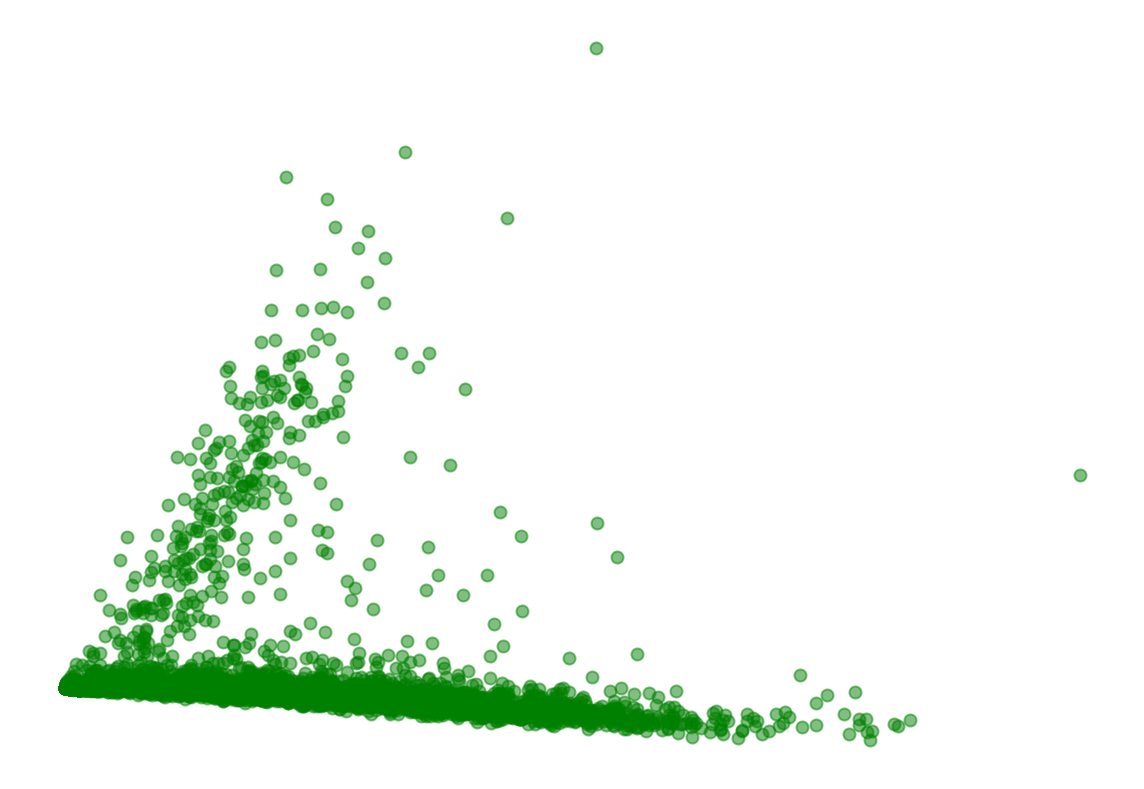

In [152]:
# Perform SVD
tsvd = TruncatedSVD(n_components=2)
tsvd.fit(adata.X)
X = tsvd.transform(adata.X)

# Plot the cells in the 2D PCA projection
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(X[:,0], X[:,1], alpha=0.5, c="green")

plt.axis('off')
plt.show()

### Test for library saturation

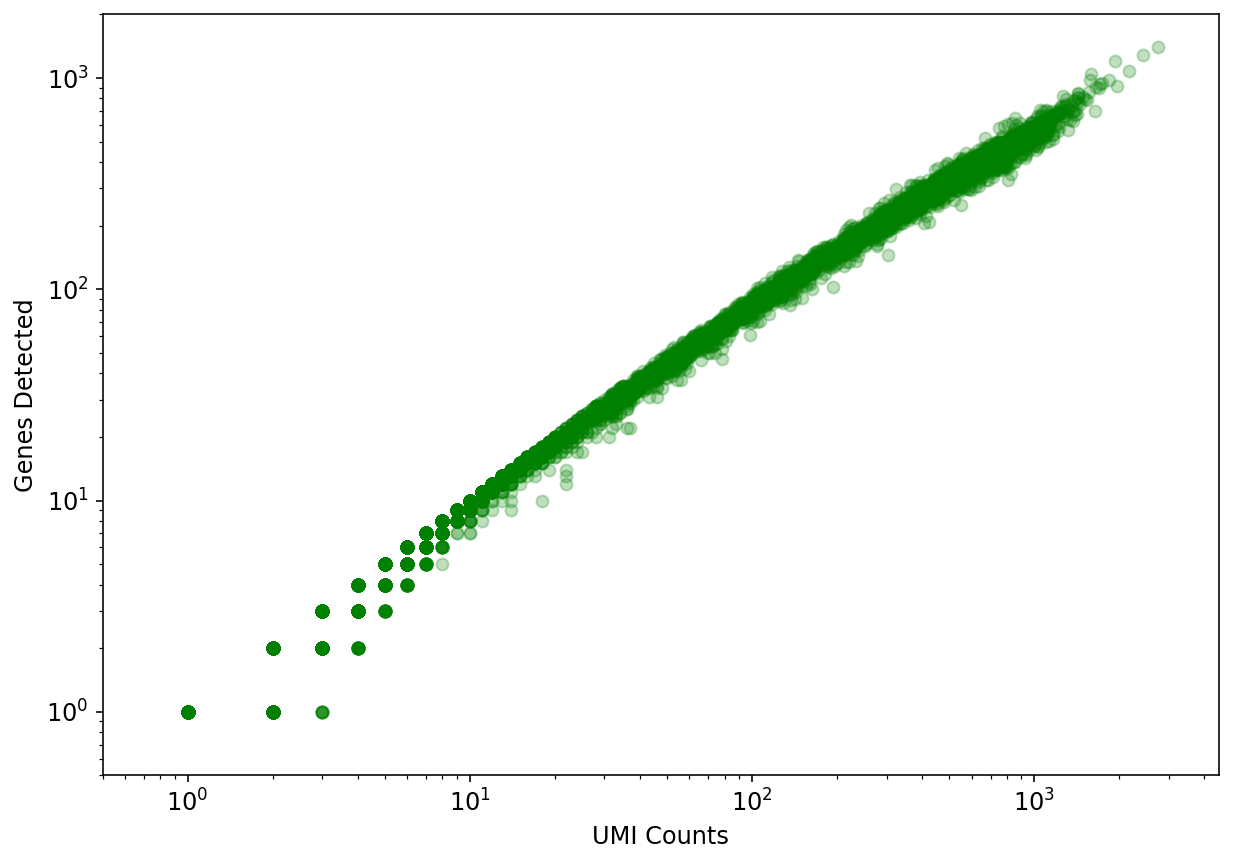

In [153]:
# Create a plot showing genes detected as a function of UMI counts.
fig, ax = plt.subplots(figsize=(10, 7))

x = np.asarray(adata.X.sum(axis=1))[:,0]
y = np.asarray(np.sum(adata.X>0, axis=1))[:,0]

ax.scatter(x, y, color="green", alpha=0.25)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log', nonposy='clip')

ax.set_xlim((0.5, 4500))
ax.set_ylim((0.5,2000))


plt.show()

### Examine the knee plot

The "knee plot" was introduced in the Drop-seq paper: 
- Macosko et al., [Highly parallel genome-wide expression profiling of individual cells using nanoliter droplets](https://www.cell.com/fulltext/S0092-8674(15)00549-8), 2015. DOI:10.1016/j.cell.2015.05.002

In this plot cells are ordered by the number of UMI counts associated to them (shown on the *x*-axis), and the fraction of droplets with at least that number of cells is shown on the *y*-axis:

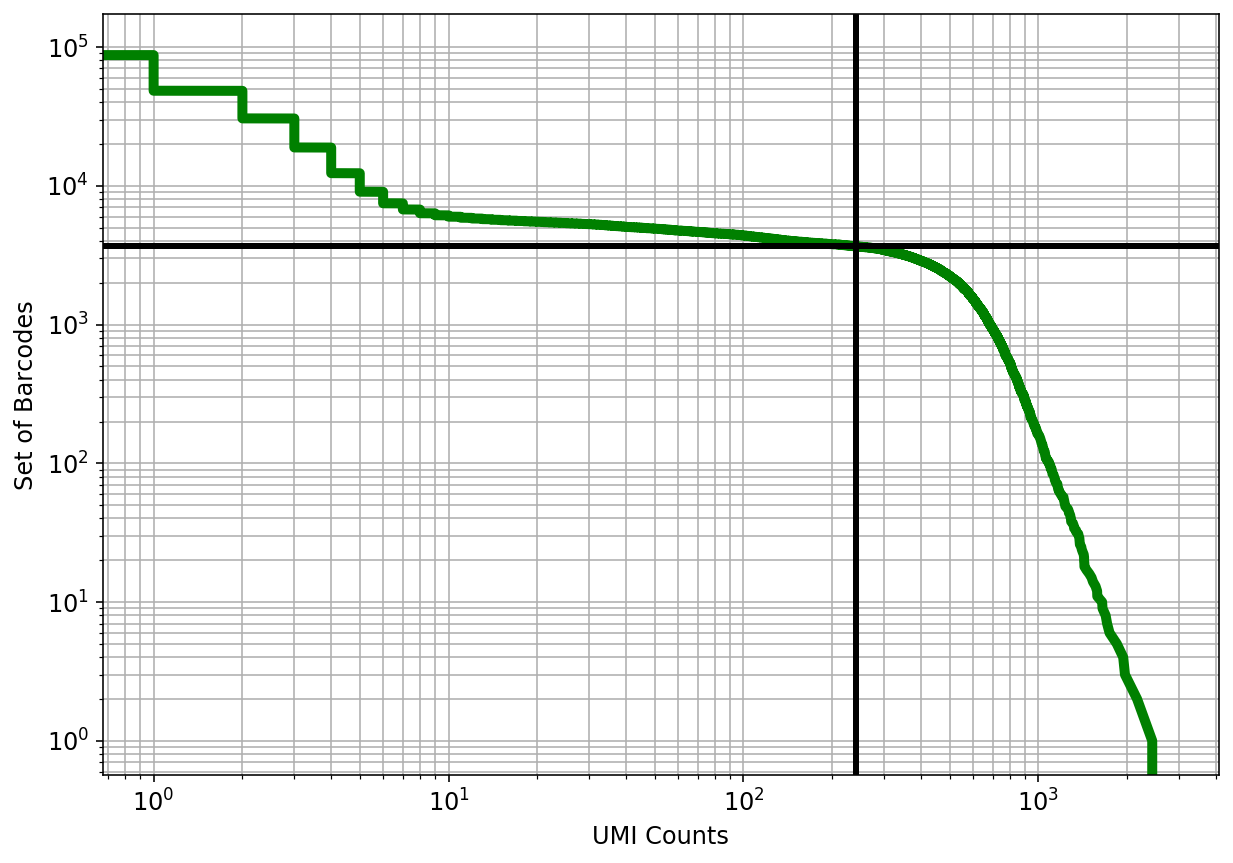

In [154]:
#@title Threshold cells according to knee plot { run: "auto", vertical-output: true }
expected_num_cells =  3655#@param {type:"integer"}
knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]

fig, ax = plt.subplots(figsize=(10, 7))

ax.loglog(knee, range(len(knee)), linewidth=5, color="g")
ax.axvline(x=knee[expected_num_cells], linewidth=3, color="k")
ax.axhline(y=expected_num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

The knee plot can be used to threshold cells based on the number of UMI counts they contain. The threshold is applied at the "knee", where there is a sharp dropoff in the number of UMIs per cell. In this example we use the nunber 3979 based on the publication describing the data.

### Filter empty droplets

In [0]:
# Filter the cells according to the threshold determined from the knee plot
sc.pp.filter_cells(adata, min_genes=0)
sc.pp.filter_cells(adata, min_counts=knee[expected_num_cells])

### Filtering out by mitochondrial content

In [0]:
mito_ensembl_ids = sc.queries.mitochondrial_genes("mmusculus", attrname="ensembl_gene_id")

In [0]:
mito_genes = mito_ensembl_ids["ensembl_gene_id"].values
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

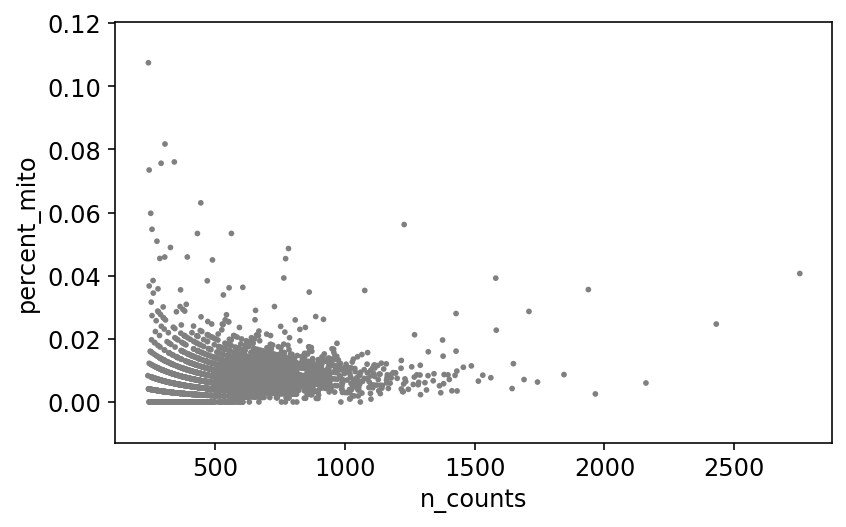

In [158]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')

In [0]:
adata = adata[adata.obs.percent_mito < 0.03]

### Filter out genes that are not present in any cells

In [160]:
sc.pp.filter_genes(adata, min_cells=1)

Trying to set attribute `.var` of view, copying.


In [161]:
adata

AnnData object with n_obs × n_vars = 3617 × 21359 
    obs: 'n_genes', 'n_counts', 'percent_mito'
    var: 'n_cells'

### Visualizing count distributions

Examination of the gene count and UMI count distributions is useful QC to evaluate the quality of the library and how deeply it was sequenced.

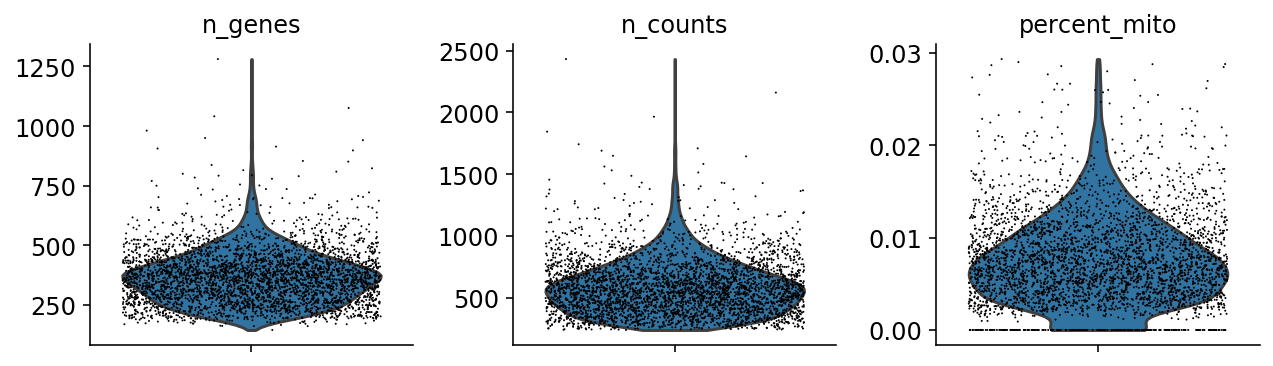

In [162]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True)

## Analysis

In this part of the tutorial, the cells are clustered by [Louvain community detection](https://en.wikipedia.org/wiki/Louvain_modularity).

### Normalize the counts

In [0]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

### Identify highly variable genes

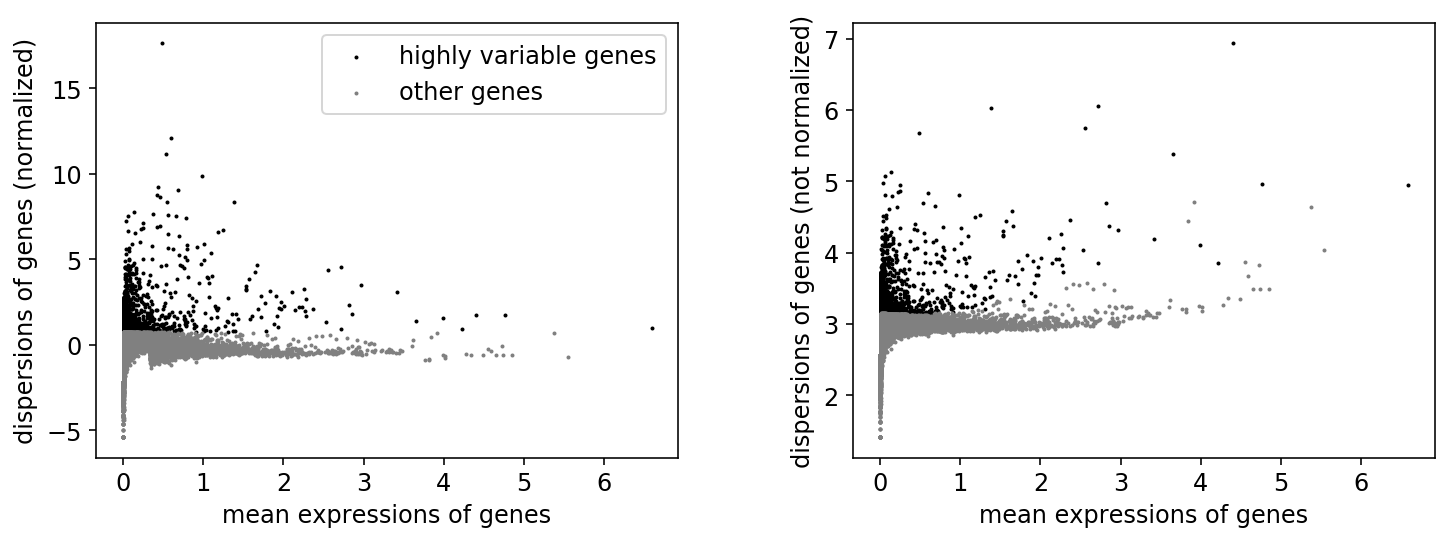

In [164]:
sc.pp.highly_variable_genes(adata, n_top_genes=3000)
sc.pl.highly_variable_genes(adata)

### Clustering and visualization

There are many algorithms for clustering cells, and while they have been compared in detail in various benchmarks (see e.g., [Duo et al. 2018](https://f1000research.com/articles/7-1141/v2)), there is no univerally agreed upon method. Here we demonstrate clustering using [Louvain clustering](https://en.wikipedia.org/wiki/Louvain_modularity), which is a popular method for clustering single-cell RNA-seq data. The method was published in 

- Blondel, Vincent D; Guillaume, Jean-Loup; Lambiotte, Renaud; Lefebvre, Etienne (9 October 2008). "Fast unfolding of communities in large networks". Journal of Statistical Mechanics: Theory and Experiment. 2008 (10): P10008.

In [165]:
%%time
# Cluster the cells using Louvain clustering
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True, n_comps=10)
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=10, knn=True)
sc.tl.louvain(adata)

CPU times: user 1.67 s, sys: 303 ms, total: 1.97 s
Wall time: 1.48 s


It is useful to revisit the PCA project with points colored by cluster. Previously we computed the PCA projection directly; here we use a function in ScanPy which does the same.

### PCA

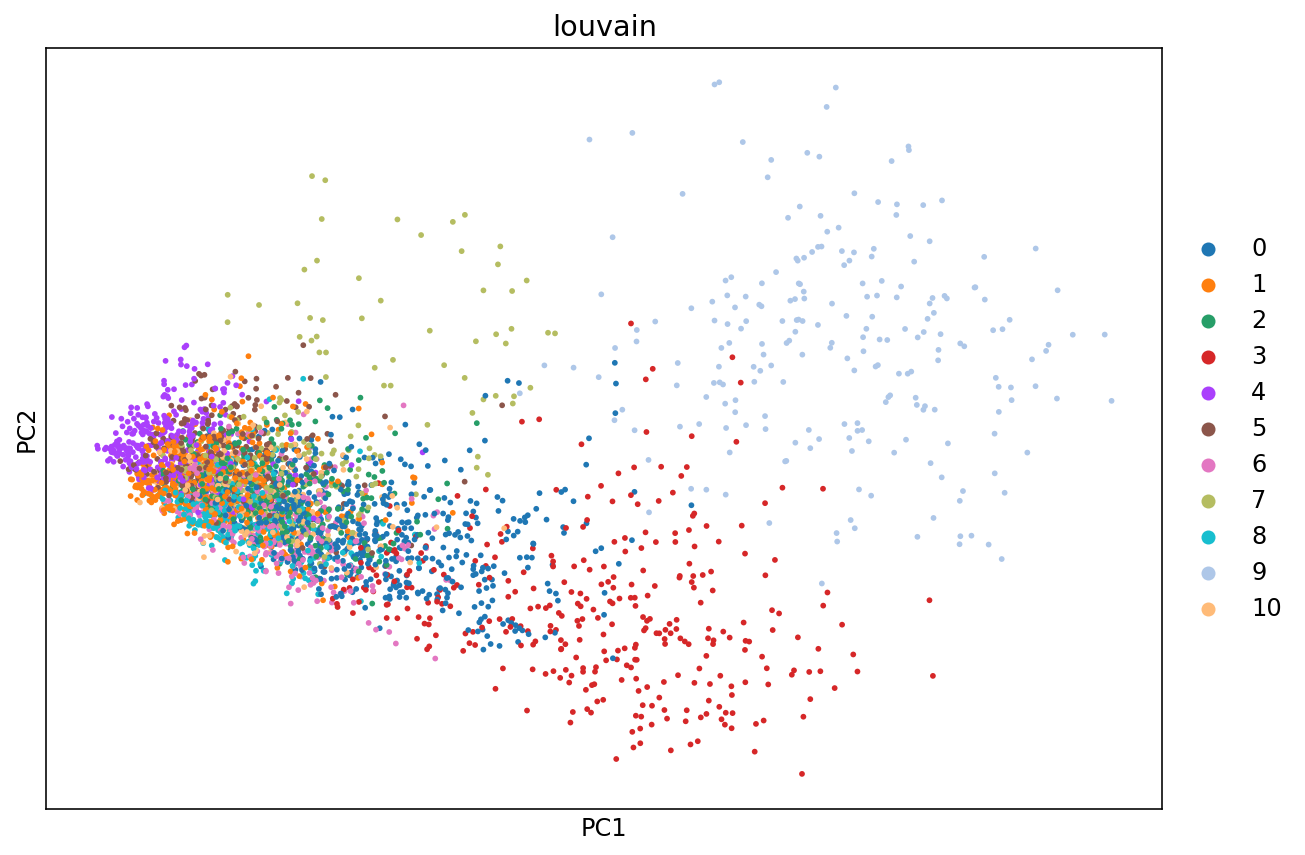

In [166]:
# Perform PCA and plot the projection to the first two dimensions, with points colored according to the Louvain clusters.
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.pca(adata, color='louvain', ax=ax)

The PCA representation is the result a *linear* map of the data from its ambient dimension, to low dimension (in the case above 2D). While such projections are useful, there are *non-linear* methods that can capture non-linear geometry in the data.

### tSNE

[t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) is a non-linear dimensionality reduction technique described in:

- Maaten, Laurens van der, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of machine learning research 9.Nov (2008): 2579-2605.

Here it is applied to the 15-dimensional PCA projection of the cells.


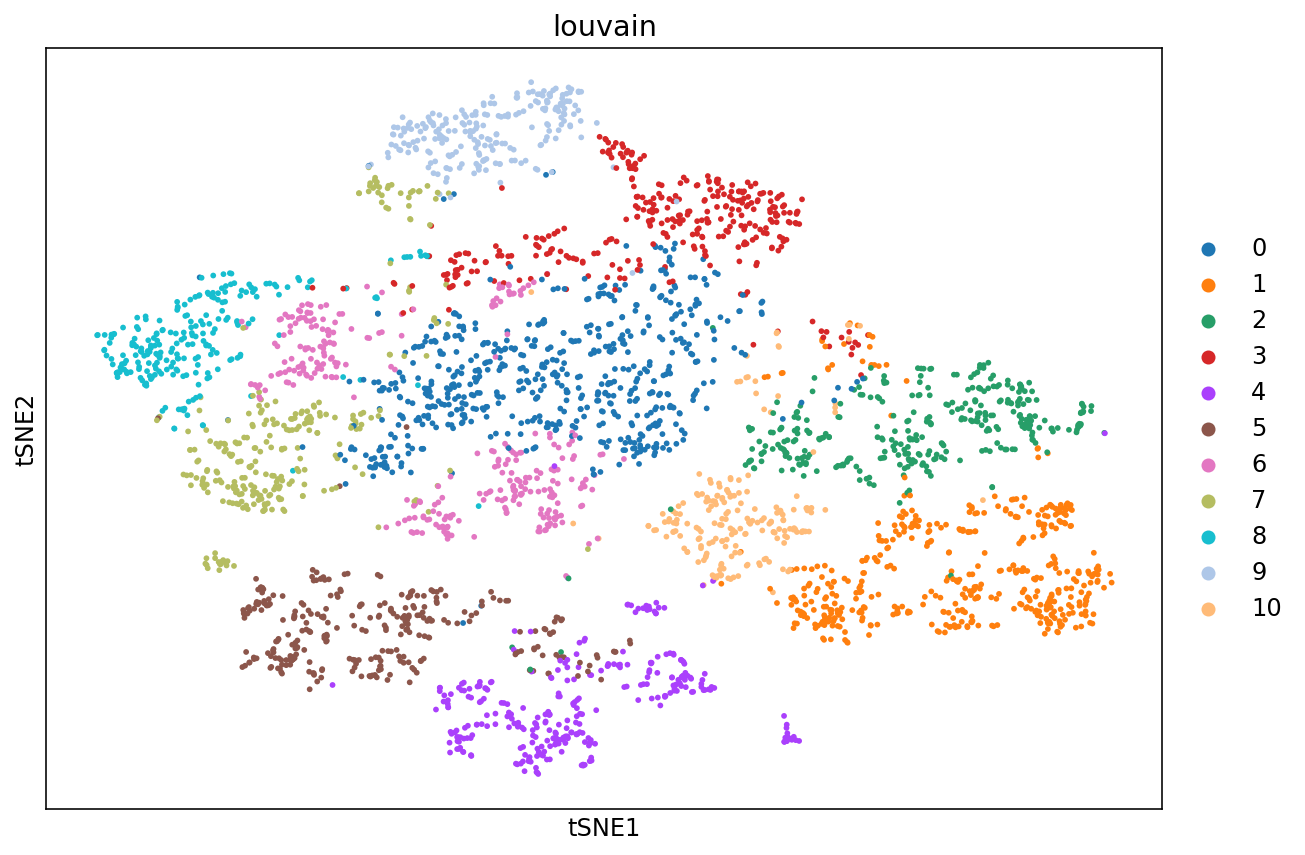

CPU times: user 22.5 s, sys: 119 ms, total: 22.6 s
Wall time: 22.5 s


In [167]:
%%time
# Visualize cells with t-SNE. The n_pcs parameter sets the number of principal components to project to prior to 
# performing t-SNE
sc.tl.tsne(adata, n_pcs=10)
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.tsne(adata, color='louvain', ax=ax)

## UMAP

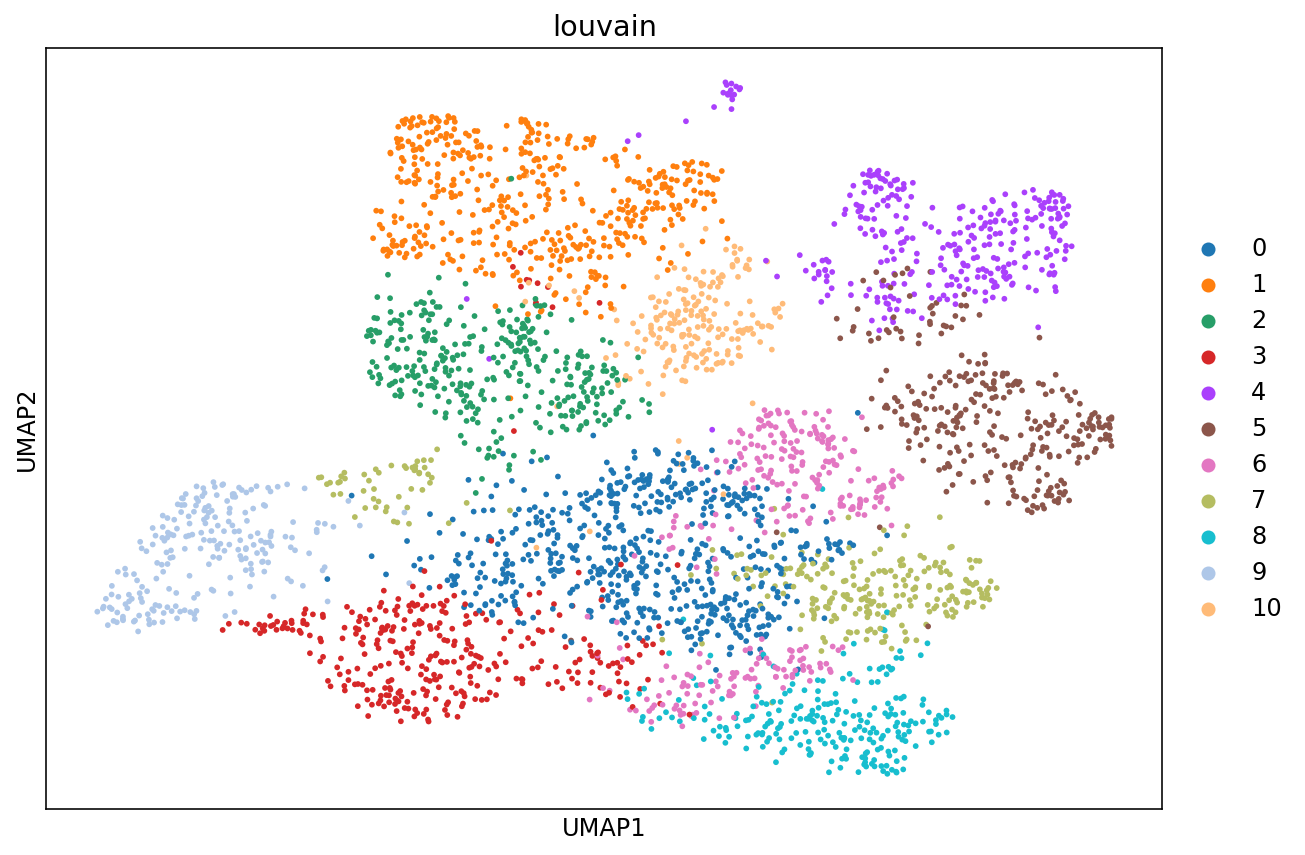

CPU times: user 12.1 s, sys: 262 ms, total: 12.3 s
Wall time: 12.1 s


In [168]:
%%time
# Visualize cells with t-SNE. The n_pcs parameter sets the number of principal components to project to prior to 
# performing t-SNE
sc.tl.umap(adata)
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.umap(adata, color='louvain', ax=ax)

### Exercises

- The variance explained by each principal component is a measure of how well a projection to that component represents the data. Compute the variance explained by each component.

In [0]:
# Compute and plot the variance explained by the PC subspaces.
# sc.pl.pca_variance_ratio(adata)

- In the notebook we visualized the data using t-SNE. Another non-linear dimensionality reduction technique that is used in single-cell RNA-seq analysis is UMAP, which stands for Uniform Manifold Approximation and Projection. Produce a UMAP of the data.

In [0]:
# %%time
# # Visualize cells with UMAP.
# sc.tl.umap(adata)
# fig, ax = plt.subplots(figsize=(10, 7))
# sc.pl.umap(adata, color='louvain', ax=ax)

## Discussion

This notebook has demonstrated visualization of cells following pre-processing of single-cell RNA-seq data.

In [25]:
# Running time of the notebook
print("{:.2f} minutes".format((time.time()-start_time)/60))

11.14 minutes


**Feedback**: please report any issues, or submit pull requests for improvements, in the [Github repository where this notebook is located](https://github.com/pachterlab/kallistobustools/blob/master/notebooks/kb_intro_2_python.ipynb).